Ce notebook a pour objectif d'étudier le nombre d'accidents mensuel en France d'un point de vue statistque afin de faire du <b>Forecasting</b>.

# Required libraries and environment :

In [55]:
import pandas as pd  # dataframe structure
from pandas import Series
from pandas import DataFrame
import numpy as np  # array structure
import seaborn as sns # visualization
import matplotlib.pyplot as plt # plot
import glob, os  # dealing with OS and Files, reading files etc 
import pickle # saving model, data, etc : serialization
from statsmodels.tsa.arima_model import ARIMA # model for forecasting 
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller # test for stationnarity
from pandas.tools.plotting import lag_plot # plot for randomness
from statsmodels.tsa.arima_model import ARIMAResults
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
from math import sqrt
import time
import datetime
import scipy
import itertools
import warnings
warnings.filterwarnings("ignore")  #ignore warning
%matplotlib inline  

# Load data : 

In [5]:
#load data : this contains information about caracteristiques of an accident
caracteristiques=pd.read_csv('data-without-imputing-all-years/caracteristiques_2005-2016.csv',encoding='latin-1')

# Prepare data : 

In [6]:
#prepare data : 
caracteristiques.loc[:,'an']=caracteristiques.loc[:,'an']+2000  # add 2000 to 'an' feature
# change type to object for easy handling : 
col_object=['an','mois','jour'] 
for col in col_object:
    caracteristiques[col]=caracteristiques[col].astype(str)
# join the three feature to obtain the date   
caracteristiques['date'] = caracteristiques[['an','mois','jour']].apply(lambda x: '-'.join(x), axis=1) 
#convert to date format
caracteristiques['date']=pd.to_datetime(caracteristiques['date'])

# Create our time series : 

In [7]:
#create a time series about the number of accidents per day :
series=caracteristiques['Num_Acc'].groupby(caracteristiques['date']).count()

# Create a monthly time series :

In [8]:
# group by month in order to have monthly data : 
series_monthly=series.resample('M', how='sum')

### Summary Statistics :

In [9]:
print(series_monthly.describe())

count     144.000000
mean     5833.229167
std      1057.484234
min      3891.000000
25%      5060.750000
50%      5651.500000
75%      6598.500000
max      8469.000000
Name: Num_Acc, dtype: float64


# Problem Description : 

Notre problématique est de pouvoir prédire le nombre d'accidents par mois en France.

Le jeu de données (series monthly) présente le nombre d'accidents par mois à partir de janvier 2005 jusqu'en décembre 2016.

# Validation Dataset :

L'ensemble de données n'est pas actuel. Cela signifie que nous ne pouvons pas facilement collecter des données mises à jour pour valider le modèle.

Nous prétendrons donc que nous sommes en septembre 2015 et retenons la dernière année de données (2016) de l'analyse et de la sélection des modèles.

Le jeu de données correspondant à l'année 2016 sera utilisé pour valider le modèle.

In [13]:
split_point = len(series_monthly) - 12
dataset, validation = series_monthly[0:split_point], series_monthly[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

Dataset 132, Validation 12


le contenu de chaque dataset est le suivant  :
    - dataset.csv : les observations à partir de anvier 2005 jusqu'en décembre 2015. C'est le jeu de donnée pour l'apprentissage.
    
    - validation.csv : les observation à partir de anvier 2016 jusqu'en décembre 2016. C'est le jeu de donnée pour la validation.

# Model Evaluation :

L'évaluation du modèle sera appliquée seulement sur le jeu de données datasetcsv préparé ci-dessus.

Cette évaluation présente deux éléments :
    1. La mesure de performance
    2. La stratégie du test 

##### La mesure de performance 

Les observations sont le nombre d'accidents par mois qui a eu lieu en France.
Nous évaluerons la performance des prédictions en utilisant l'erreur quadratique moyenne (RMSE). Cela donnera plus de poids aux prédictions qui sont grossièrement fausses et auront les mêmes unités que les données originales.

##### La stratégie du test 

Les modèles candidats seront évalués en utilisant la validation anticipée (<b>walk-forward validation</b>). 
En effet, un modèle de type rolling-forecast est requis à partir de la définition du problème. C'est là que les prévisions en une étape sont nécessaires compte tenu de tout l'historique disponible.

La méthode <b>walk-forward</b> est la suivante :
    1. Les premiers 50 % de l'ensemble de données seront retenus pour l'apprentissage du modèle.
    2. Les 50 % restants de l'ensemble de données seront itérés et testeront le modèle. 
    3. Pour chaque itération sur le jeu du test : 
        1. Un modèle sera formé
        2. Une prédiction en une étape,  et cette prédiction sera stockée pour une évaluation ultérieure.
        3. L'observation actuelle de l'ensemble de données du test sera ajoutée à l'ensemble de données d'apprentissage pour l'itération suivante.
    4. Les prédictions faites pendant l'itération sur  l'ensemble de données du test seront évaluées via la mesure RMSE.

# Persistence

La première étape avant de commencer l'analyse et la modélisation des données consiste à établir une base de performance ( comme les dummy classifier en classification ou encore  dummy regressor en regréssion).

La prédiction de base pour la prévision de séries chronologiques est appelée prévision naïve, ou persistance.

C'est ici que l'observation de l'étape précédente est utilisée comme prédiction de l'observation au pas de temps suivant.

In [19]:
# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=6724.000, Expected=6451
>Predicted=6451.000, Expected=5288
>Predicted=5288.000, Expected=6592
>Predicted=6592.000, Expected=6777
>Predicted=6777.000, Expected=6098
>Predicted=6098.000, Expected=4662
>Predicted=4662.000, Expected=5062
>Predicted=5062.000, Expected=4518
>Predicted=4518.000, Expected=5520
>Predicted=5520.000, Expected=5892
>Predicted=5892.000, Expected=6282
>Predicted=6282.000, Expected=5876
>Predicted=5876.000, Expected=5566
>Predicted=5566.000, Expected=4888
>Predicted=4888.000, Expected=6131
>Predicted=6131.000, Expected=6162
>Predicted=6162.000, Expected=5411
>Predicted=5411.000, Expected=5666
>Predicted=5666.000, Expected=5057
>Predicted=5057.000, Expected=3983
>Predicted=3983.000, Expected=5201
>Predicted=5201.000, Expected=4572
>Predicted=4572.000, Expected=5340
>Predicted=5340.000, Expected=5746
>Predicted=5746.000, Expected=5399
>Predicted=5399.000, Expected=4546
>Predicted=4546.000, Expected=5845
>Predicted=5845.000, Expected=6049
>Predicted=6049.000,

Dans ce cas, nous pouvons voir que le modèle de persistance a atteint une RMSE de 669.488. Cela signifie qu'en moyenne, le modèle s'est trompé d'environ 669 d'accidents pour chaque prédiction faite.

Maintenant que nous avons un modèle de base, nous pouvons commencer à voir les données pour les modéliser.

# Data Analysis

### Vérifier le caractére chronologique de la série : 

La modélisation des séries chronologiques suppose une relation entre une observation et l'observation précédente.

Les observations précédentes dans une série temporelle sont appelées des  décalages, l'observation à l'étape précédente appelée lag1, l'observation à deux pas de temps lag2 et ainsi de suite.

Un tracé utile pour explorer la relation entre chaque observation et un décalage de cette observation est appelé le nuage de points (lag plot).

Pandas a une fonction intégrée pour faire exactement ce qu'on appelle lag plot. Il trace l'observation à l'instant t sur l'axe des abscisses et l'observation lag1 (t-1) sur l'axe des ordonnées.

1. Si les points se regroupent le long d'une ligne diagonale de la partie inférieure gauche à la partie supérieure droite de la courbe, cela suggère une relation de corrélation positive.
2. Si les points se regroupent le long d'une ligne diagonale du haut à gauche au bas à droite, cela suggère une relation de corrélation négative.


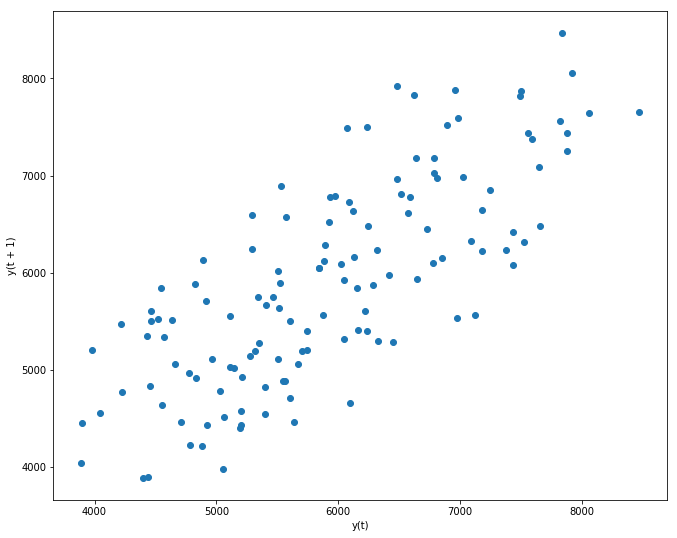

In [70]:
lag_plot(series)
pyplot.show()

Les points ne sont pas aléatoires et montrent une tendance linéaire.
Puisqu'il s'agit très bien d'une série chronologique, nous allons maintenant étudier la stationnaritéde la série.

### Visualisations : 

#### Line Plot :

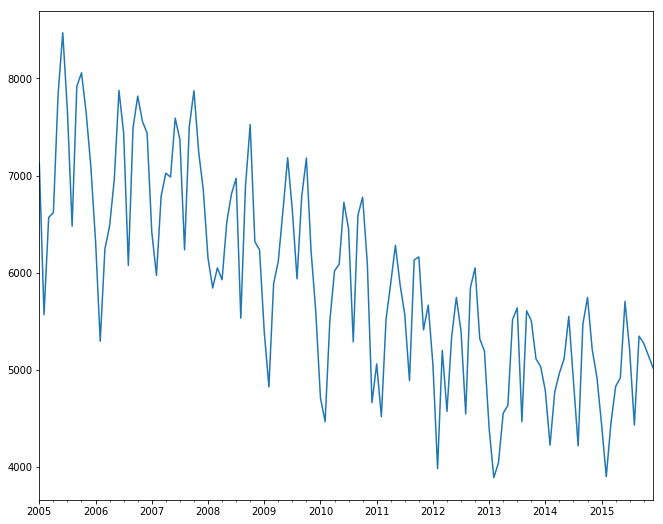

In [59]:
# plot for the whole period : 
rcParams['figure.figsize'] = 11, 9
series.plot()
pyplot.show()

- Il y a une tendance de décroissance du nombre d'accidents au cours du temps.
- On voit l'aspect saisonnier des variations
- Le signal saisonnier semble diminuer avec le temps, ce qui suggère une relation multiplicative (l'importance de l'effet saisonnier diminue lorsque les valeurs de la série diminuent).
- Il semble que le jeu de données ne présente pas de points aberrants
- La saisonnalité suggère que la série est presque certainement non stationnaire.

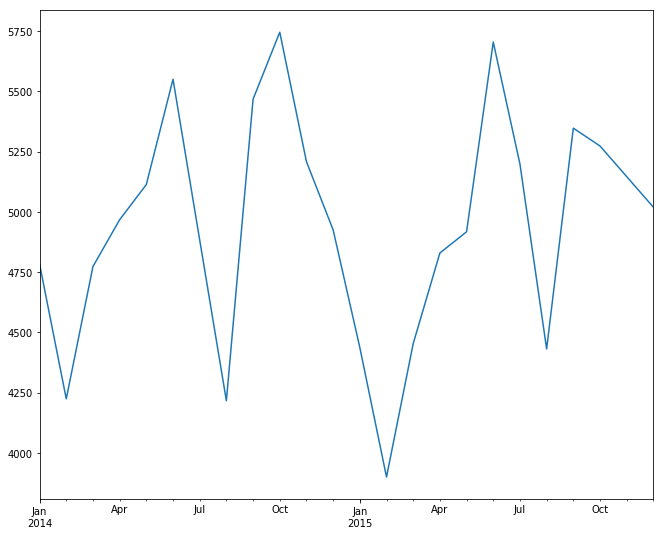

In [23]:
# plot for the whole period : 
rcParams['figure.figsize'] = 11, 9
series[series.index > '2014'].plot()
pyplot.show()

- On peut remarquer que le nombre d'accidents est assez élevé en octobre et Juin.
- Par contre en février et août on a peu d'accidents.

#### Seasonal Line Plots

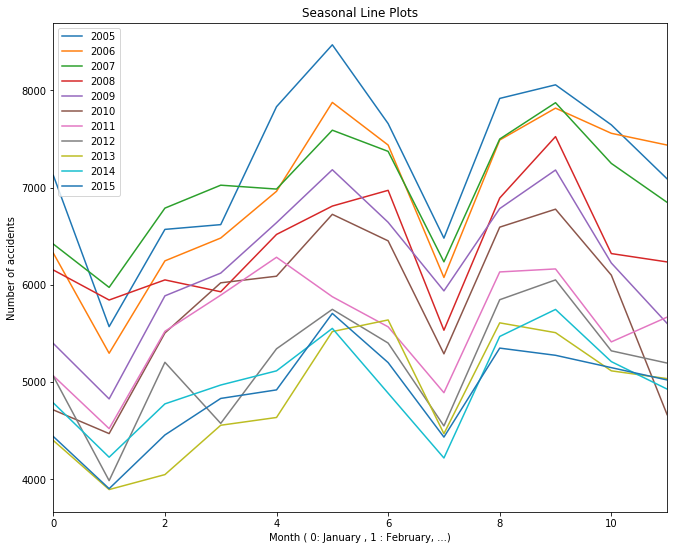

In [69]:
series = Series.from_csv('dataset.csv')
groups = series.groupby(TimeGrouper('A'))
years = DataFrame()
for name, group in groups:
	years[name.year] = group.values
years.plot(subplots=False, legend=True)
plt.xlabel('Month ( 0: January , 1 : February, ...)')
plt.ylabel('Number of accidents')
plt.title('Seasonal Line Plots')
plt.show()

On peut citer les remarques suivantes : 
    1. Le nombre d'accidents atteint son minumum chaque année en Février et Août
    2. Le nombre d'accidents atteint son maximum chaque année en Juin et Octobre.

#### Box et Whisker Plots :

Nous pouvons regrouper les données mensuelles par année et avoir une idée de la répartition des observations pour chaque année et de la façon dont cela pourrait changer.

Nous nous attendons à voir une certaine tendance (diminution de la  moyenne ou de la médiane), mais il peut être intéressant de voir comment le reste de la distribution peut changer.

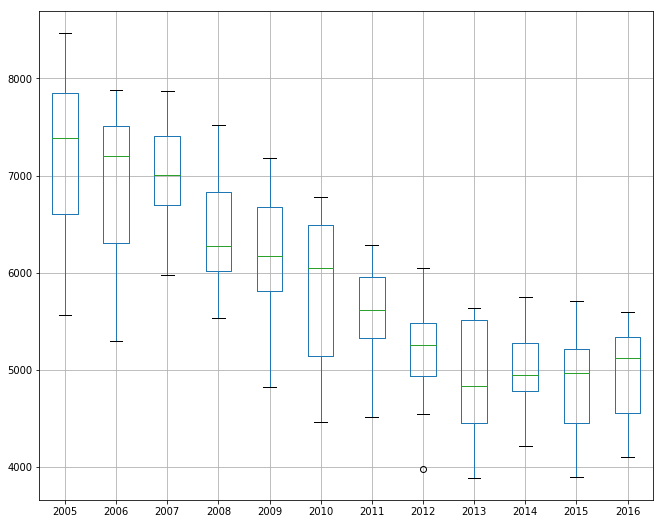

In [12]:
from pandas import Series
from pandas import DataFrame
from pandas import TimeGrouper
from matplotlib import pyplot
groups = series_monthly['2005':'2016'].groupby(TimeGrouper('A'))
years = DataFrame()
for name, group in groups:
    years[name.year] = group.values
years.boxplot()
pyplot.show()

Commentaires: 

    1- pas de points aberrants
    
    2- la médiane diminue avec le temps jusqu'en 2013 puis augmente

# ARIMA Models

Le modèle ARIMA (p, d, q) nécessite trois paramètres et est traditionnellement configuré manuellement.

L'analyse des données de séries chronologiques suppose que nous travaillons avec une série temporelle stationnaire.

La série chronologique est presque certainement non stationnaire. Nous pouvons le rendre stationnaire en différenciant d'abord la série et en utilisant un test statistique pour confirmer que le résultat est stationnaire.

## Stationnarité de notre série temporelle

Une série temporelle est dite stationnaire si ses propriétés statistiques telles que la moyenne, la variance restent constantes dans le temps. Mais pourquoi est-ce important? La plupart des modèles de séries chronologiques supposent que la série temporelle est stationnaire. Intuitivement, on peut dire que si une série temporelle a un comportement particulier au cours du temps, il y a une très forte probabilité que cela se reproduise dans le futur. De plus, les théories relatives aux séries stationnaires sont plus matures et plus faciles à mettre en œuvre que les séries non stationnaires.

La stationnarité est définie en utilisant un critère très strict. Cependant, pour des raisons pratiques, nous pouvons supposer que la série est stationnaire si elle a des propriétés statistiques constantes dans le temps, c-à-d le suivant:

    1. moyenne constante
    2. variance constante
    3. une autocovariance qui ne dépend pas du temps

Pour tester la stationnarité de la série, on dispose des méthodes suivantes :

<b>Plotting Rolling Statistics</b> : Nous pouvons tracer la moyenne mobile ou la variance en mouvement et voir si elle varie avec le temps. En faisant varier la moyenne / variance, on veux dire qu'à tout instant t, nous prendrons la moyenne / variance de la dernière année, c'est-à-dire les 12 derniers mois. Mais encore une fois c'est plus d'une technique visuelle.

<b>Dickey-Fuller Test</b> : C'est l'un des tests statistiques pour vérifier la stationnarité. Ici l'hypothèse nulle est que la série temporelle est non-stationnaire. Les résultats du test comprennent une statistique de test et quelques valeurs critiques pour les niveaux de confiance de différence. Si la «statistique de test» est inférieure à la «valeur critique», nous pouvons rejeter l'hypothèse nulle et dire que la série est stationnaire

In [72]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

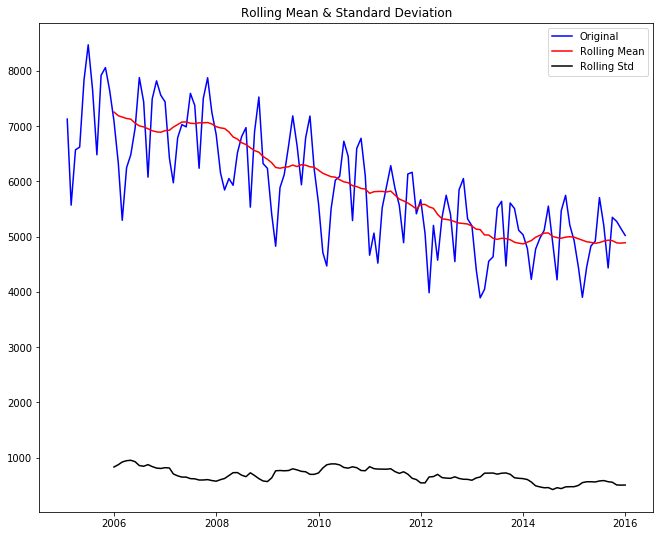

Results of Dickey-Fuller Test:
Test Statistic                  -0.953630
p-value                          0.769799
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


In [73]:
rcParams['figure.figsize'] = 11, 9
# i will use the whole data by droping nan values corresponding to 2009
test_stationarity(series)

Bien que la variation de l'écart type soit faible, la moyenne diminue nettement avec le temps et il ne s'agit pas d'une série stationnaire. En effet : 

- p-value >>>0.05 
- De plus Test  Statistic est supérieure aux Critical Value, ce qui confirme encore que la série n'est pas stationnaire.

## Rendre la série temporelle stationnaire 

Bien que l'hypothèse de stationnarité soit prise dans de nombreux modèles de séries temporelles, presque aucune série temporelle pratique n'est stationnaire. Les statisticiens ont donc trouvé des façons de rendre la série stationnaire, dont nous allons discuter maintenant.

Allons comprendre ce qui rend une série temporelle non stationnaire. Il y a 2 raisons principales derrière la non-stationnarité d'une série temporelle :

<b>Tendance</b> : moyenne variable au fil du temps. Par exemple, dans ce cas, nous avons vu qu'en moyenne, le nombre d'accidents diminue avec le temps.

<b>Saisonnalité</b> : variations à des périodes spécifiques. par exemple, le nombre d'accidents est important pendant Octobre( début de la pluie peut être ?! et Juin( les gens partent en vacances beaucoup donc le traffic ?)

### <b> Differencing: </b>

L'une des méthodes les plus courantes pour faire face à la fois à la tendance et à la saisonnalité est la différenciation. Dans cette technique, nous prenons la différence de l'observation à un instant particulier avec celle de l'instant précédent. Cela fonctionne principalement bien dans l'amélioration de la stationnarité.

La saisonnalité dans la série est apparemment d'année en année. Les données saisonnières peuvent être différenciées en soustrayant l'observation de la même période dans le cycle précédent, dans ce cas le même mois de l'année précédente. Cela signifie que nous allons perdre la première année d'observations car il n'y a pas d'année précédente pour faire la différence avec.

L'exemple ci-dessous crée une version désaisonnalisée de la série et l'enregistre dans le fichier stationary.csv.

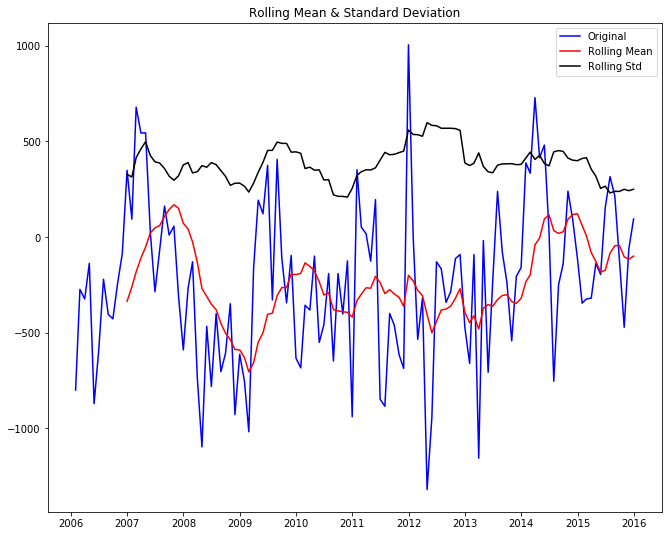

Results of Dickey-Fuller Test:
Test Statistic                  -3.776313
p-value                          0.003159
#Lags Used                      11.000000
Number of Observations Used    108.000000
Critical Value (1%)             -3.492401
Critical Value (5%)             -2.888697
Critical Value (10%)            -2.581255
dtype: float64


In [82]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
series = Series.from_csv('dataset.csv')
X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
stationary = difference(X, months_in_year)
stationary.index = series.index[months_in_year:]
# check if stationary
test_stationarity(stationary)
# save
stationary.to_csv('stationary.csv')


génial! on remarque maintenant que le série est devenue parfaitement stationnaire : 
    1. p-value<<<0.05
    2. Test Statistic est inférieur aux Critical Value
Donc on rejette l'hypothèse nulle, d'où la série est devenue stationnaire.

## Forecasting pour notre série temporelle :

Nous avons vu différentes techniques et toutes ont fonctionné raisonnablement bien pour rendre les séries chronologiques stationnaires. Faisons un modèle sur la série temporelle après la différenciation car c'est une technique très populaire. En outre, il est relativement plus facile d'ajouter du bruit et de la saisonnalité dans les résidus prévus dans ce cas. 

Nous commençons par   une brève introduction d'<b>ARIMA</b>.  ARIMA est l'abréviation de Moyennes mobiles intégrées auto-régressives. La méthode ARIMA pour une série temporelle stationnaire n'est rien d'autre qu'une équation linéaire (comme une régression linéaire). Les prédicteurs dépendent des paramètres (p, d, q) du modèle ARIMA : 

1. <b>Nombre de termes AR (autorégressifs) (p)</b>: Les termes AR ne sont que des décalages de la variable dépendante. Par exemple, si p vaut 5, les prédicteurs pour x(t) seront x (t-1) ... .x (t-5).
 
2. <b>Nombre de termes MA (moyenne mobile) (q)</b>: Les termes MA sont des erreurs de prévision retardées dans l'équation de prédiction. Par exemple, si q est 5, les prédicteurs pour x (t) seront e (t-1) ... e (t-5) où e (i) est la différence entre la moyenne mobile à sa valeur instantanée et sa valeur réelle.
 
3. <b>Nombre de différences (d)</b>: Il s'agit du nombre de différences non saisonnières, c'est-à-dire dans ce cas que nous avons pris la différence de premier ordre. Donc, soit nous pouvons passer cette variable et mettre d = 0 ou passer la variable d'origine et mettre d = 1. Les deux vont générer les mêmes résultats.

Une question importante  est de savoir comment déterminer la valeur de 'p' et 'q'. Nous utilisons deux graphiques pour déterminer ces nombres. Discutons alors ces deux graphiques :

1. <b>Fonction d'autocorrélation (ACF)</b>: C'est une mesure de la corrélation entre la série temporelle et une version décalée d' elle-même. Par exemple pour un décalage de  5, ACF comparera la série aux instants 't1' ... 't2' avec la série aux instants 't1-5' ... 't2-5' (t1-5 et t2 étant les points d'extrémité).
2. <b>Fonction d'autocorrélation partielle (PACF, partial auto autocorrelation function)</b>: elle mesure la corrélation entre la série temporelle et une version décalée d'elle-même, mais après élimination des variations déjà expliquées par les comparaisons intermédiaires. Par exemple, au décalage 5, il vérifie la corrélation mais supprime les effets déjà expliqués par les décalages 1 à 4.

Les graphiques ACF et PACF pour la série temporelle après différentiation peuvent être tracés comme suit: 

In [60]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

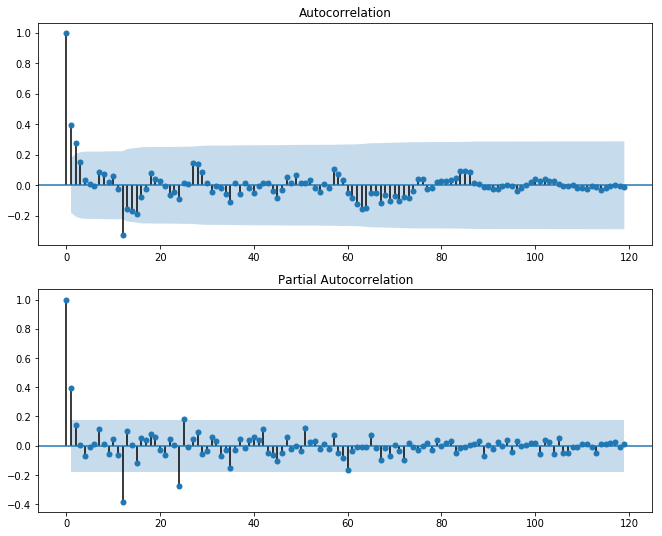

In [84]:
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
series = Series.from_csv('stationary.csv')
plt.figure()
plt.subplot(211)
plot_acf(series, ax=pyplot.gca())
plt.subplot(212)
plot_pacf(series, ax=pyplot.gca())
plt.show()

A partir des graphique ci-dessus : 
    1. q = 1 (ACF) 
    2. p = 2 (PACF)
A noter qu'il ne faut pas compter le lag en 0.

Cette analyse rapide suggère qu'un modèle ARIMA (2,0,1) sur les données stationnaires peut être un bon point de départ.

L'expérimentation montre que cette configuration d'ARIMA ne converge pas et entraîne des erreurs de la bibliothèque sous-jacente (<b>LinAlgError: SVD did not converge</b>).Donc la solution pertinente est d'ajouter un autre niveau de différenciation aux données stationnaires. Le modèle peut être étendu à ARIMA (2,1,1).

In [89]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff
 
# invert differenced value : 

def inverse_difference(history, yhat, interval=1):
    
    '''to make predictions directly comparable to 
    the expected observation in the original accidents count units
    '''
    return yhat + history[-interval]
 
# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(2,1,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=6211.341, Expected=6451
>Predicted=5654.688, Expected=5288
>Predicted=6342.507, Expected=6592
>Predicted=6846.759, Expected=6777
>Predicted=5900.735, Expected=6098
>Predicted=5353.068, Expected=4662
>Predicted=4187.483, Expected=5062
>Predicted=4163.923, Expected=4518
>Predicted=5519.695, Expected=5520
>Predicted=5942.738, Expected=5892
>Predicted=5947.572, Expected=6282
>Predicted=6663.228, Expected=5876
>Predicted=6131.522, Expected=5566
>Predicted=4630.850, Expected=4888
>Predicted=6110.461, Expected=6131
>Predicted=6392.964, Expected=6162
>Predicted=5641.574, Expected=5411
>Predicted=4135.859, Expected=5666
>Predicted=5112.113, Expected=5057
>Predicted=4618.179, Expected=3983
>Predicted=5199.393, Expected=5201
>Predicted=5555.981, Expected=4572
>Predicted=5642.783, Expected=5340
>Predicted=5166.468, Expected=5746
>Predicted=5232.796, Expected=5399
>Predicted=4653.182, Expected=4546
>Predicted=5831.749, Expected=5845
>Predicted=5860.242, Expected=6049
>Predicted=5177.020,

L'exécution de cet exemple donne une valeur RMSE de 426.621, ce qui est meilleur par rapport à la RMSE de persistance (669.488).

C'est un très bon début, mais on peut encore améliorer les résultats en faisant un grid search pour les paramètres (p,d,q).

### Grid Search ARIMA Hyperparameters

Les graphiques ACF et PACF suggèrent qu'un ARIMA (2,0,1)  peut être le meilleur modèle.

Pour confirmer cette analyse, nous pouvons rechercher dans une grille une série d'hyperparamètres ARIMA et vérifier qu'aucun modèle n'améliore la performance de l'échantillon RMSE.

Dans cette section, nous allons rechercher les valeurs de p, d et q pour les combinaisons (en ignorant celles qui ne convergent pas) et trouver la combinaison qui donne les meilleures performances sur l'ensemble de test. Nous allons utiliser une recherche de grille pour explorer toutes les combinaisons dans un sous-ensemble de valeurs entières.

<mark>Remarque : cette recherche prend du temps car il cherche toutes les combinaisons possibles.</mark>

In [90]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.50)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		# difference data
		months_in_year = 12
		diff = difference(history, months_in_year)
		model = ARIMA(diff, order=arima_order)
		model_fit = model.fit(trend='nc', disp=0)
		yhat = model_fit.forecast()[0]
		yhat = inverse_difference(history, yhat, months_in_year)
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	mse = mean_squared_error(test, predictions)
	rmse = sqrt(mse)
	return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s RMSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 
#load dataset
series = Series.from_csv('dataset.csv')
# evaluate parameters
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=452.578
ARIMA(0, 0, 2) RMSE=446.195
ARIMA(0, 0, 3) RMSE=439.926
ARIMA(0, 0, 4) RMSE=442.124
ARIMA(0, 0, 5) RMSE=466.304
ARIMA(0, 1, 1) RMSE=447.839
ARIMA(0, 1, 2) RMSE=445.812
ARIMA(0, 2, 1) RMSE=512.444
ARIMA(1, 0, 0) RMSE=443.106
ARIMA(1, 0, 1) RMSE=434.081
ARIMA(1, 1, 0) RMSE=471.425
ARIMA(1, 1, 1) RMSE=434.459
ARIMA(1, 2, 0) RMSE=663.419
ARIMA(2, 0, 0) RMSE=437.497
ARIMA(2, 1, 0) RMSE=466.070
ARIMA(2, 1, 1) RMSE=426.621
ARIMA(2, 2, 0) RMSE=597.258
ARIMA(2, 2, 1) RMSE=469.059
ARIMA(3, 0, 0) RMSE=439.053
ARIMA(3, 1, 0) RMSE=467.579
ARIMA(3, 2, 0) RMSE=575.788
ARIMA(3, 2, 1) RMSE=471.004
ARIMA(4, 0, 0) RMSE=443.616
ARIMA(4, 0, 1) RMSE=445.472
ARIMA(4, 1, 0) RMSE=470.130
ARIMA(4, 1, 1) RMSE=456.733
ARIMA(4, 1, 2) RMSE=457.866
ARIMA(4, 1, 3) RMSE=430.495
ARIMA(4, 2, 0) RMSE=583.341
ARIMA(4, 2, 1) RMSE=473.408
ARIMA(5, 0, 0) RMSE=451.835
ARIMA(5, 0, 2) RMSE=447.595
ARIMA(5, 1, 0) RMSE=470.808
ARIMA(5, 1, 1) RMSE=458.153
ARIMA(5, 1, 2) RMSE=451.276
ARIMA(5, 2, 0) RMSE=

Donc notre choix qu'on effectué en utilisant seulement les graphiques ACF et PACF est le meilleur.

Donc on garde le modèle <b>ARIMA(2,1,1)</b>

### Review Residual Errors

Une bonne vérification finale d'un modèle consiste à examiner les erreurs de prévision résiduelles.
Idéalement, la distribution des erreurs résiduelles devrait être gaussienne avec une moyenne nulle.

                 0
count    66.000000
mean     49.453720
std     426.991889
min    -983.981483
25%    -183.063235
50%      94.646960
75%     258.803961
max    1530.141430


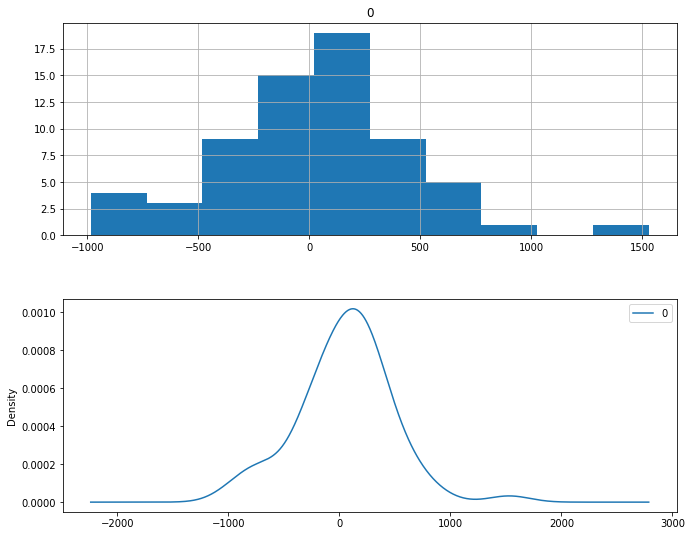

In [91]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(2,1,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
plt.figure()
plt.subplot(211)
residuals.hist(ax=pyplot.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
plt.show()

- Les graphiques suggèrent une distribution de type gaussien avec une queue gauche bosselée, fournissant une preuve supplémentaire que peut-être une transformation  pourrait valoir la peine d'être explorée. 
- la moyenne est non nulle avec une valeur de 49.45, donc les résultats sont baisés

Nous pourrions utiliser cette information pour corriger les prédictions en ajoutant l'erreur résiduelle moyenne de 49.45 à chaque prévision faite.

RMSE: 423.745
                 0
count    66.000000
mean      0.003720
std     426.991889
min   -1033.431483
25%    -232.513235
50%      45.196960
75%     209.353961
max    1480.691430


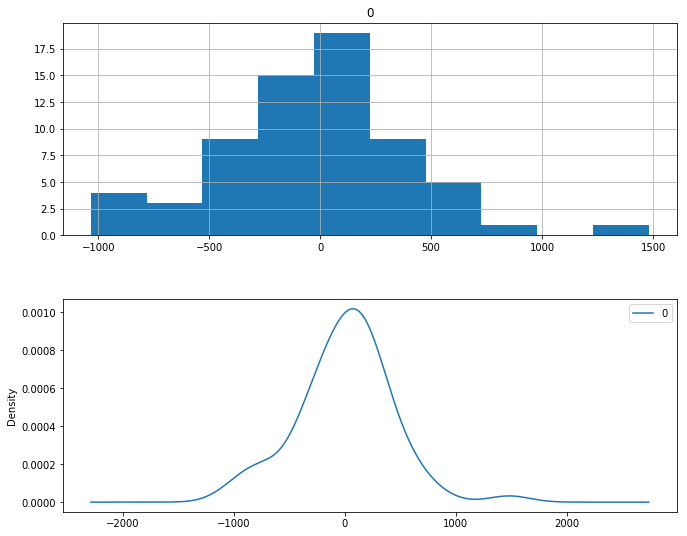

In [94]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
bias = 49.45
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(2,1,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
plt.figure()
plt.subplot(211)
residuals.hist(ax=pyplot.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
plt.show()


La performance des prédictions est très légèrement améliorée de 426.621 à 423.745, ce qui peut être significatif ou non.

Les graphiques des résidus ainsi que leurs descriptions statistiques montrent que  la moyenne est devenue quasiment nulle (0.003)

# Model Validation

### Finalise Model :

La finalisation du modèle implique l'apprentissage d'un modèle ARIMA sur l'ensemble de données complet.

In [98]:
# monkey patch around bug in ARIMA class : to fix error about loading a saved
#  model
def __getnewargs__(self):
	return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))
 
ARIMA.__getnewargs__ = __getnewargs__
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff
 
# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
diff = difference(X, months_in_year)
# fit model
model = ARIMA(diff, order=(2,1,1))
model_fit = model.fit(trend='nc', disp=0)
# bias constant, could be calculated from in-sample mean residual
bias = 49.45
# save model
model_fit.save('model.pkl') # save ARIMAResult object (This includes the coefficients 
#               and all other internal data returned when fitting the model.)
numpy.save('model_bias.npy', [bias]) #This is the bias value stored as a one-row, 
#                                    one-column NumPy array.

### Make Prediction

Un cas naturel peut être de charger le modèle et de faire une seule prévision.

Ceci est relativement simple et implique de restaurer le modèle enregistré et le biais et d'appeler la méthode forecast(). Pour inverser la différenciation saisonnière, les données historiques doivent également être chargées.

L'exemple ci-dessous charge le modèle, effectue une prédiction pour le pas de temps suivant et affiche la prédiction.

In [100]:
from statsmodels.tsa.arima_model import ARIMAResults
series = Series.from_csv('dataset.csv')
months_in_year = 12
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(series.values, yhat, months_in_year)
print('Predicted: %.3f' % yhat)

Predicted: 4390.334


Si nous regardons à l'intérieur de validation.csv, nous pouvons voir que la valeur sur la première ligne pour la prochaine période est 4802. Etant la prédiction une valeur de 4390.334, on peut dire que le modèle est sur le bon chemin.

### Validate Model

Nous pouvons charger le modèle et l'utiliser de manière opérationnelle.

Dans les sections précédentes, nous avons sauvegardé les 12 derniers mois de l'ensemble de données original dans un fichier séparé pour valider le modèle final.

Nous pouvons maintenant charger ce fichier validation.csv et l'utiliser pour voir si notre modèle est vraiment bon sur  des données invisibles.

Pour avoir de bons résultats de prédiction sur les données invisibles, on va procéder la manière suivante :

>Predicted=4390.334, Expected=4802
>Predicted=3980.097, Expected=4101
>Predicted=4520.640, Expected=4599
>Predicted=4854.661, Expected=4430
>Predicted=4733.029, Expected=5139
>Predicted=5656.262, Expected=5328
>Predicted=5044.387, Expected=5252
>Predicted=4323.100, Expected=4311
>Predicted=5255.712, Expected=5408
>Predicted=5214.341, Expected=5596
>Predicted=5213.423, Expected=5356
>Predicted=5098.181, Expected=5110
RMSE: 270.140


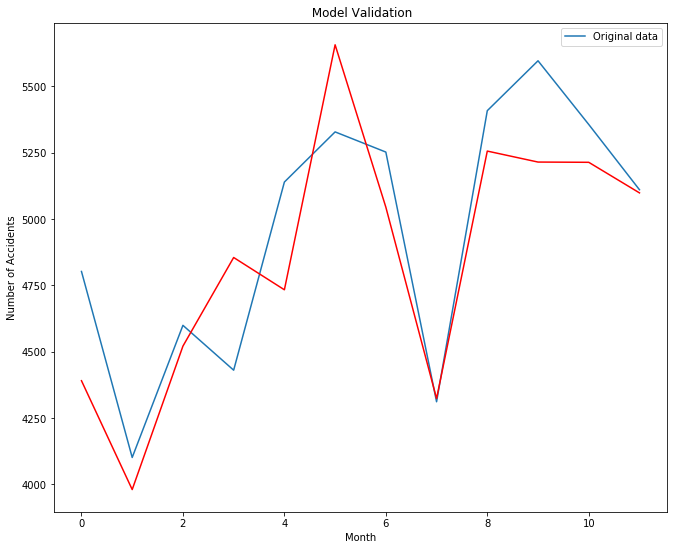

In [113]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# load and prepare datasets
dataset = Series.from_csv('dataset.csv')
X = dataset.values.astype('float32')
history = [x for x in X]
months_in_year = 12
validation = Series.from_csv('validation.csv')
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, months_in_year)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(2,1,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = y[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(y, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
plt.plot(y)
plt.legend(['Original data']) 
plt.plot(predictions, color='red')

plt.xlabel('Month')
plt.ylabel('Number of Accidents')
plt.title(' Model Validation')
plt.show()


La RMSE sur le jeu de validation est de 270.14, ce qui est un très bon score.

À partir du graphique ci-dessus on peut dire notre modèle a bien prédit les données invisibles avec un très bon score.

# Conclusion: 

Cette étude nous a montré qu'un modèle ARIMA(2,1, 1) donne de très bons résultats pour prédire le nombre d'accidents mensuels en France. Ceci permet de dire que le phénomène des accidents  est chronologique avec des propriétés de saisonnalité et de tendance décroissante. l'État doit prendre ces résultats en considération dans la mesure où il reste toujours des causes derrière les accidents qui doivent être étudiés avec rigueur pour diminuer le nombre d'accidents. À noter qu'un accident coûte pour l'État un budget assez important, donc diminuer le nombre d'accidents permet d'utiliser ce budget dans d'autres projets qui contribue à l'évolution économique du pays.  

## Points à discuter :

1. Pourquoi le nombre d'accidents augmente en octobre et juin ? Quels conseils fournir à l'État pour régler ce problème ?
2. En voyant le nombre d'accident en février et août, comment peut-on diminuer ceux en octobre et juin ? 
3. Quels sont les facteurs derières les accidents. 

Pour répondre à ces questions, on a choisi de travailler sur la gravité des accidents corporels afin de trouver les facteurs qui définissent cette gravité. Trouver ces facteurs ne va pas permettre forcément de diminuer le nombre d'accidents parce qu'on ne dispose pas d'autres données sur les personnes en relation avec un accident ( vitesse, l'alcool, la fatigue,  le cannabis, usage du téléphone, etc.  ),  mais va diminuer la gravité des accidents et donc ne pas perdre du budget.

# Bibliographie :

Cette étude a été inspiré des deux études sur les liens suivants : 

https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/